In [1]:
import pandas as pd
import xgboost as xgb
from xgboost import *
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, cross_validate, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
import numpy as np
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import sys
sys.path.append('/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/DATA7901 Capstone project/Capstone/Models/Functions')
from Evaluation import *
from Preparation import *
import pickle

In [2]:
X, y, data = preparation_class_threshold()

/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/DATA7901 Capstone project/Capstone/Models/Functions/Preparation.py:717: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_location = pd.read_csv('../../Dataset/Location.csv')


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [4]:
smoteenn_model = pickle.load(open("Saved_models_remove/lgbm_smote.pkl", 'rb'))

### Re-training on new features with baseline model

In [5]:
lgbm_classifier = smoteenn_model.named_steps['lgbmclassifier']

### Feature importance selection

In [6]:
feature_importances = lgbm_classifier.feature_importances_
feature_importances = feature_importances / np.sum(feature_importances)
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
features_df = features_df.sort_values(by='Importance', ascending=False)
top_20_features = features_df.head(20)
top_30_features = features_df.head(30)
top_40_features = features_df.head(40)
top_50_features = features_df.head(50)
top_60_features = features_df.head(60)
top_70_features = features_df.head(70)
top_80_features = features_df.head(80)

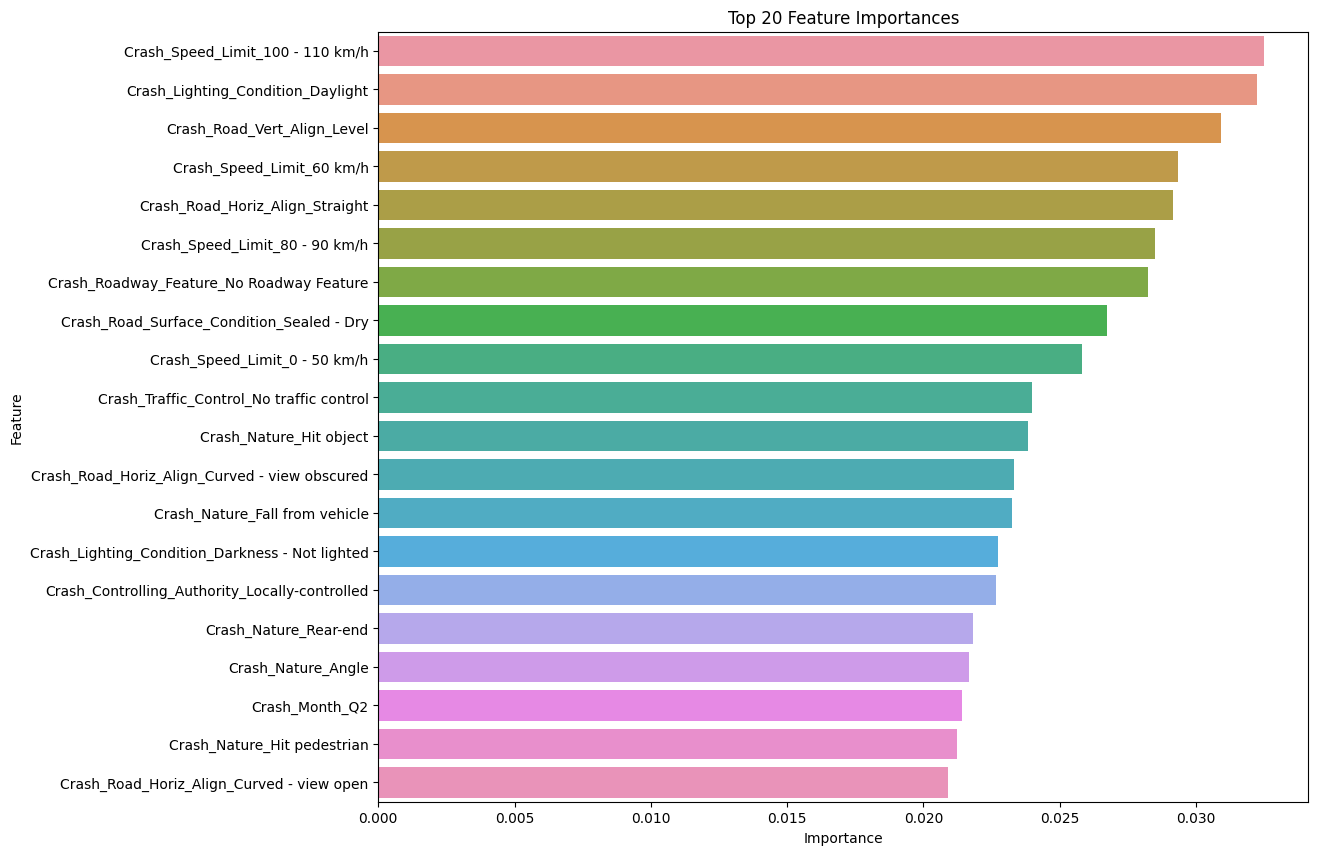

In [9]:
feature_importances = lgbm_classifier.feature_importances_
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
features_df = features_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=top_20_features)
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### 20 Features with baseline

Accuracy:  0.6188638997155799
Precision:  0.49469902560987444
Recall:  0.6188638997155799
F1-Score:  0.49582919648676477
--------------------------------------------
                 precision    recall  f1-score   support

          Fatal       0.20      0.00      0.00      1166
   Minor injury       0.00      0.00      0.00     10409
Property damage       0.46      0.06      0.11     17442
 Serious injury       0.62      0.98      0.76     46927

       accuracy                           0.62     75944
      macro avg       0.32      0.26      0.22     75944
   weighted avg       0.49      0.62      0.50     75944



/Users/ayoucruz/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayoucruz/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayoucruz/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayoucruz/miniconda3/li

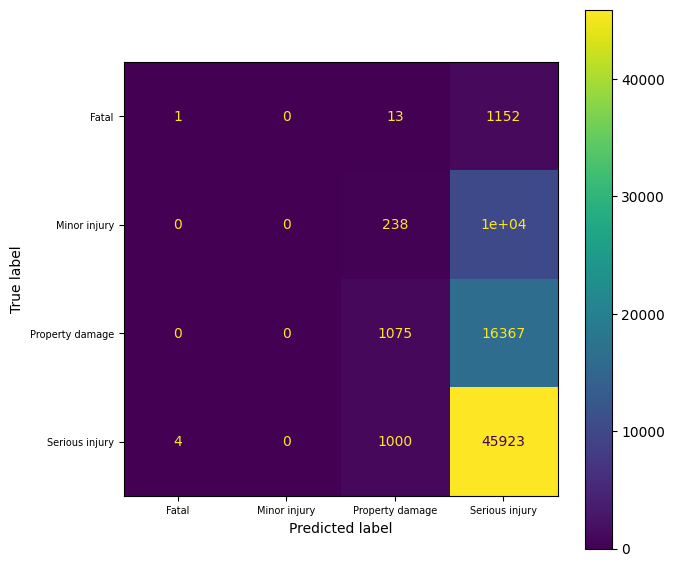

/Users/ayoucruz/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.6188638997155799
Precision:  0.49469902560987444
Recall:  0.6188638997155799
F1-Score:  0.49582919648676477


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X[top_20_features.Feature], y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
xgb_model = XGBClassifier(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
evaluation_class_8(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred, average='weighted'))
print("Recall: ", recall_score(y_test, y_pred, average='weighted'))
print("F1-Score: ", f1_score(y_test, y_pred, average='weighted'))

### Feature selection

In [6]:
import shap

explainer = shap.Explainer(smoteenn_model.named_steps['xgbclassifier'], X_test.values)
shap_values = explainer(X_test.values)# Use values to convert to numpy array

100%|===================| 303081/303208 [36:21<00:00]        

In [8]:
import shap
shap_values = pickle.load(open("shapanalysis/shap_values_remove.pkl", 'rb'))

Text(0.5, 1.0, 'Class: Fatal injury SHAP Values')

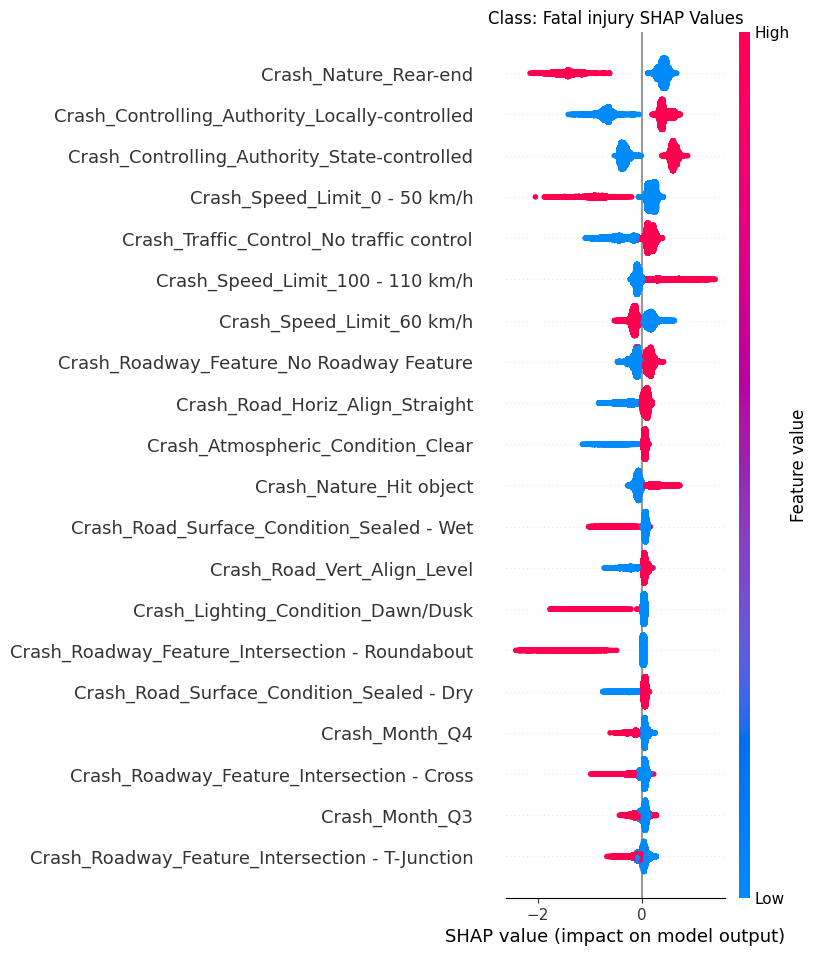

In [20]:
# Visualizing for the first class (index 0)
class_shap_values = shap_values[:, :, 0]
shap.summary_plot(class_shap_values, X_test.values, feature_names=X_test.columns.tolist(), show=False)
plt.title(f'Class: {"Fatal injury"} SHAP Values')

Text(0.5, 1.0, 'Class: Minor injury SHAP Values')

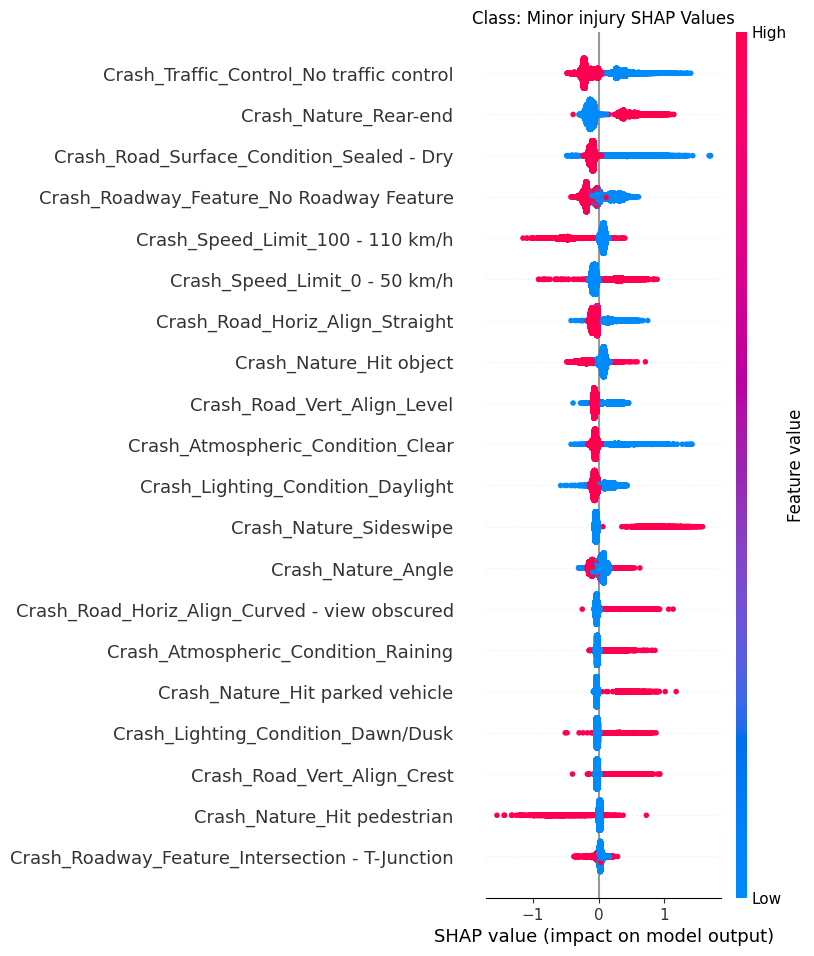

In [11]:
# Visualizing for the first class (index 0)
class_shap_values = shap_values[:, :, 1]

shap.summary_plot(class_shap_values, X_test.values, feature_names=X_test.columns.tolist(), show=False)
plt.title(f'Class: {"Minor injury"} SHAP Values')

Text(0.5, 1.0, 'Class: Property damage SHAP Values')

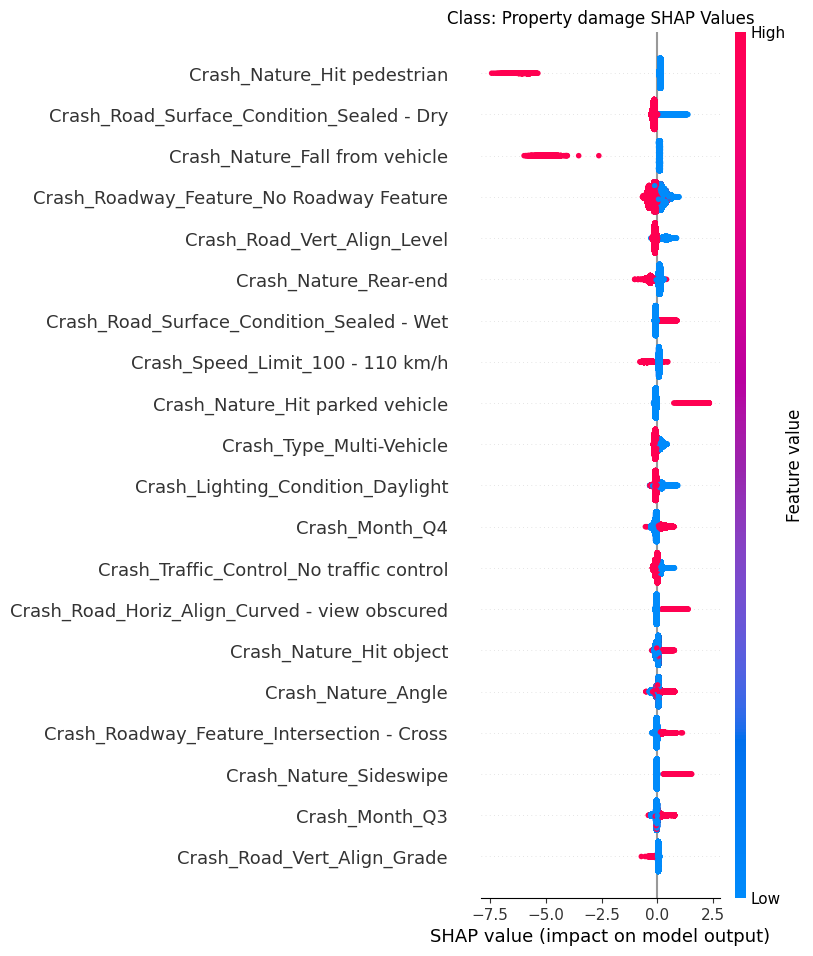

In [12]:
# Visualizing for the first class (index 0)
class_shap_values = shap_values[:, :, 2]

shap.summary_plot(class_shap_values, X_test.values, feature_names=X_test.columns.tolist(), show=False)
plt.title(f'Class: {"Property damage"} SHAP Values')

Text(0.5, 1.0, 'Class: Serious injury SHAP Values')

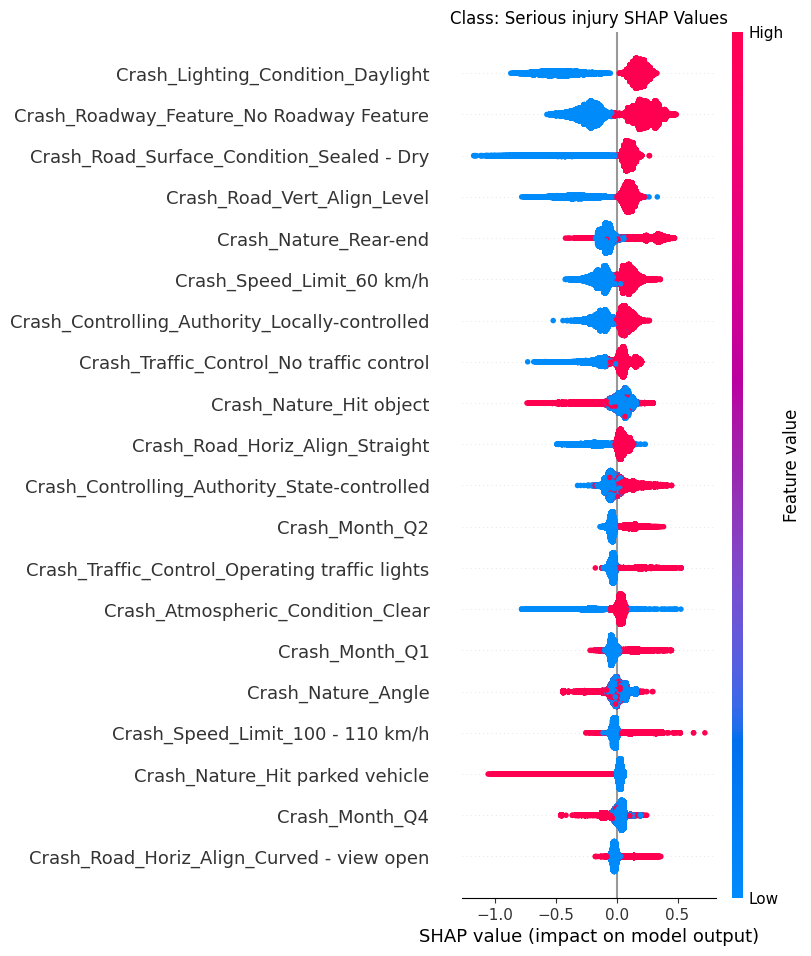

In [13]:
# Visualizing for the first class (index 0)
class_shap_values = shap_values[:, :, 3]

shap.summary_plot(class_shap_values, X_test.values, feature_names=X_test.columns.tolist(), show=False)
plt.title(f'Class: {"Serious injury"} SHAP Values')

In [11]:
with open('shap_values_remove.pkl', 'wb') as file:
    pickle.dump(shap_values, file)